<a href="https://colab.research.google.com/github/srujana345/Malicious-URL-detection/blob/main/Malicious_URL_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d sid321axn/malicious-urls-dataset
!chmod 600 /content/kaggle.json

 53% 9.00M/16.9M [00:00<00:00, 78.9MB/s]
100% 16.9M/16.9M [00:00<00:00, 105MB/s] 


In [ ]:
!unzip \*.zip && rm *.zip

Archive:  malicious-urls-dataset.zip
  inflating: malicious_phish.csv     


In [ ]:
import nltk
import hashlib
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import re
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

**DATA**

In [ ]:
df = pd.read_csv("malicious_phish.csv")
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


**PREPROCESSING**

In [ ]:
print(df.shape)
df['type'].unique()

(651191, 2)


array(['phishing', 'benign', 'defacement', 'malware'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['category']  = encoder.fit_transform(df['type'])
df

,url,type,category
0,br-icloud.com.br,phishing,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3


In [ ]:
df.drop_duplicates()
df.shape

(651191, 3)

In [ ]:
df.dropna()
df.shape

(651191, 3)

In [ ]:
def length(url):
  return len(url)

def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)'
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)
    if match:
        return 1
    else:
        return 0

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits
def has_shortening_service(url):
    pattern = re.compile(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                         r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                         r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                         r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                         r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                         r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                         r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                         r'tr\.im|link\.zip\.net')
    match = pattern.search(url)
    return int(bool(match))
def abnormal_url(url):
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname
    if hostname:
        hostname = str(hostname)
        match = re.search(hostname, url)
        if match:
            return 1
    return 0

def secure_http(url):
    scheme = urlparse(url).scheme
    if scheme == 'https':
        return 1000
    else:
        return 0
def have_ip_address(url):
    pattern = r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)' \
              r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|' \
              r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|' \
              r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'

    match = re.search(pattern, url)
    if match:
        return 1
    else:
        return 0

def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count("/")
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',url)
    if match:
        return 1
    else:
        return 0
def getPortN(url):
    try:
        parsedUrl = urlparse(url)
        if (parsedUrl.scheme == ''):
            port = urlparse('http://'+url).port
        else:
            port = parsedUrl.port
        if port is None:
            return 80
        else:
            return port
    except:
        return 80
def subdomain_length(url):
    parsed_url = urlparse(url)
    subdomain = parsed_url.hostname.split('.')[0]
    if subdomain != None:
      return len(subdomain)
    else:
      return 0

In [ ]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',']
x = 0
for a in feature:
  df[a] = df['url'].apply(lambda i: i.count(a))

In [ ]:
df['length'] = df['url'].apply(lambda x : length(x))
df['having_ip_address'] = df['url'].apply(lambda x : having_ip_address(x))
df['count_digits'] = df['url'].apply(lambda x : count_digits(x))
df['abnormal_url'] = df['url'].apply(lambda x : abnormal_url(x))
df['has_shortening_service'] = df['url'].apply(lambda x : has_shortening_service(x))
df['secure_http'] = df['url'].apply(lambda x : secure_http(x))
df['no_of_dir'] = df['url'].apply(lambda x : no_of_dir(x))
df['getPortN'] = df['url'].apply(lambda x : getPortN(x))

In [ ]:
df.loc[:,'url']

0                                          br-icloud.com.br
1                       mp3raid.com/music/krizz_kaliko.html
2                           bopsecrets.org/rexroth/cr/1.htm
3         http://www.garage-pirenne.be/index.php?option=...
4         http://adventure-nicaragua.net/index.php?optio...
                                ...                        
651186              xbox360.ign.com/objects/850/850402.html
651187         games.teamxbox.com/xbox-360/1860/Dead-Space/
651188           www.gamespot.com/xbox360/action/deadspace/
651189        en.wikipedia.org/wiki/Dead_Space_(video_game)
651190            www.angelfire.com/goth/devilmaycrytonite/
Name: url, Length: 651191, dtype: object

In [ ]:
df.describe()

,category,@,?,-,=,.,#,%,+,$,...,*,",",length,having_ip_address,count_digits,abnormal_url,has_shortening_service,secure_http,no_of_dir,getPortN
count,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,...,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000,651191.000000
mean,0.681567,0.002219,0.223782,1.550421,0.603863,2.195453,0.000871,0.519502,0.068432,0.000238,...,0.000395,0.004823,60.156831,0.019177,5.527249,0.288686,0.061050,24.078957,2.317042,412.233914
std,1.088137,0.054183,0.441220,2.973790,1.516960,1.490732,0.032327,4.462254,0.621276,0.023544,...,0.074938,0.152428,44.753902,0.137147,11.700686,0.453152,0.239422,153.294477,1.566924,3970.398108
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,80.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,47.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,80.000000
75%,1.000000,0.000000,0.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,77.000000,0.000000,7.000000,1.000000,0.000000,0.000000,3.000000,80.000000
max,3.000000,10.000000,20.000000,87.000000,51.000000,42.000000,6.000000,231.000000,37.000000,6.000000,...,54.000000,15.000000,2175.000000,1.000000,1204.000000,1.000000,1.000000,1000.000000,39.000000,65509.000000


<ipython-input-17-ecf5339f40cc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


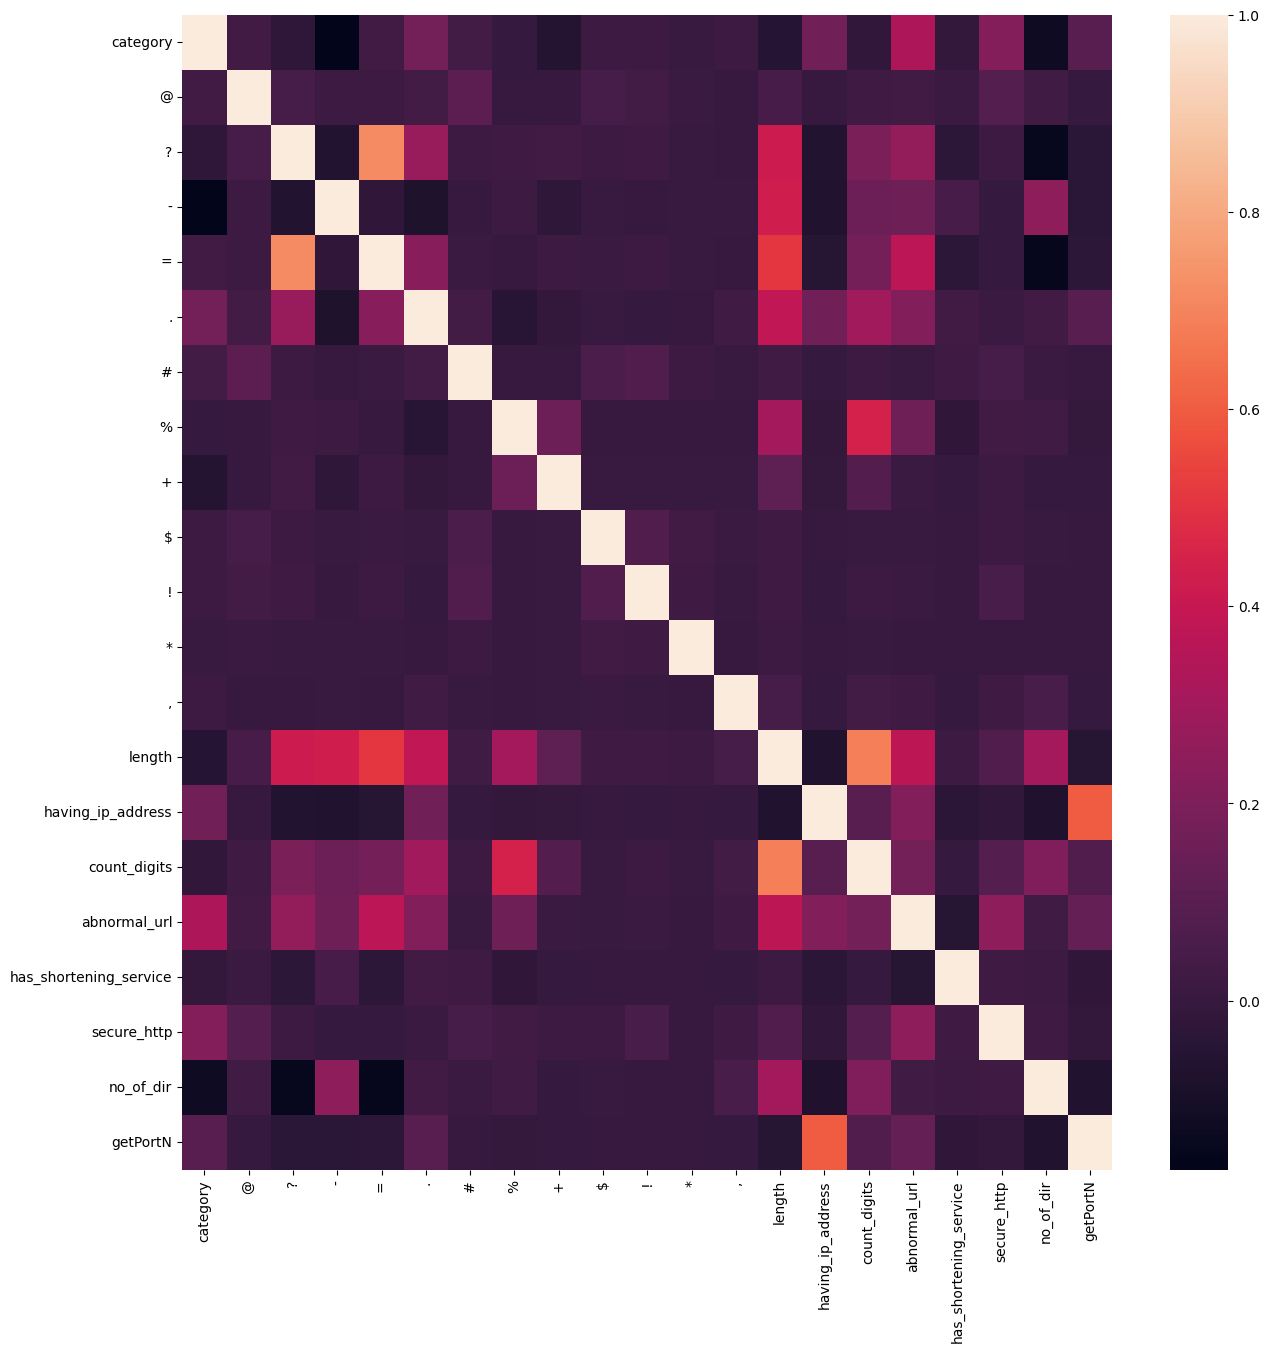

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr())
plt.show()

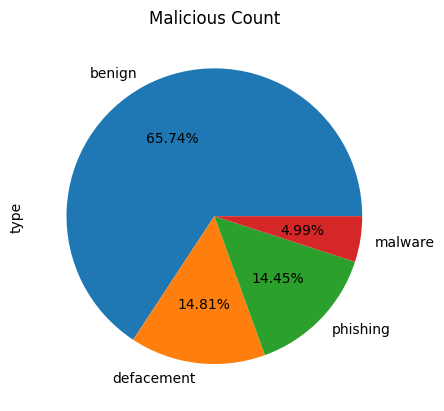

In [ ]:
df['type'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.title("Malicious Count")
plt.show()

0 : benign
1 : defacement
2 : malware
3 : phishing

In [ ]:
from collections import Counter
Counter(df['type'])

Counter({'phishing': 94111,
         'benign': 428103,
         'defacement': 96457,
         'malware': 32520})

In [ ]:
sampled_df = df.sample(n = 500000, random_state=42)

In [ ]:
X = sampled_df.iloc[:,3:]
y = sampled_df.iloc[:,2]
X_train2,X_test2,y_train2,y_test2 = train_test_split(X,y,test_size = 0.2)

In [ ]:
classifier5 = GaussianNB()
classifier5.fit(X_train2, y_train2)

GaussianNB()

In [ ]:
y_pred6 = classifier5.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred6)
print(cm)
accuracy_score(y_test2, y_pred6)

[[60989  3966   543   382]
 [   78 14653     0     2]
 [  404  1232  2267   969]
 [10922  2357   162  1074]]


0.78983

In [ ]:
classifier3 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier3.fit(X_train2, y_train2)

KNeighborsClassifier()

In [ ]:
y_pred4 = classifier3.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred4)
print(cm)
accuracy_score(y_test2, y_pred4)

[[63020   492   105  2263]
 [  624 13818    75   216]
 [  241   161  4225   245]
 [ 4530   714   168  9103]]


0.90166

In [ ]:
RandomForestClassifieclf2 = RandomForestClassifier(n_estimators = 100 ,  criterion = "gini")
RandomForestClassifieclf2.fit(X_train2,y_train2)

RandomForestClassifier()

In [ ]:
ypre = RandomForestClassifieclf2.predict(X_test2)
accuracy_score(y_test2, ypre)

0.92697

In [ ]:
import pickle
with open('final.pkl', 'wb') as model_file:
    pickle.dump(RandomForestClassifieclf2, model_file)